<a href="https://colab.research.google.com/github/Zamuruev/BI/blob/master/%D0%94%D0%BE%D0%B1%D1%80%D0%BE_%D0%BF%D0%BE%D0%B6%D0%B0%D0%BB%D0%BE%D0%B2%D0%B0%D1%82%D1%8C_%D0%B2_Colaboratory!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Код для генерации черно-белого изображания с кругами и квадратами.

Изображение сохранено как 'shapes_image.png'


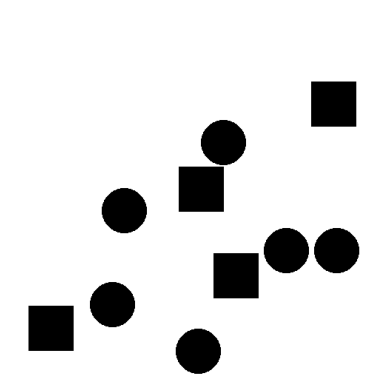

In [8]:
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt  # Для отображения изображения

# Параметры изображения
IMAGE_SIZE = (500, 500)  # Размер изображения
CIRCLE_RADIUS = 30       # Радиус кругов
SQUARE_SIZE = 60         # Размер стороны квадрата
NUM_SHAPES = 10          # Общее количество фигур (кругов и квадратов)

# Создаем новое изображение
image = Image.new("1", IMAGE_SIZE, color=1)  # "1" означает черно-белый режим
draw = ImageDraw.Draw(image)

# Функция для проверки пересечения двух прямоугольников
def is_overlapping(rect1, rect2):
    """
    Проверяет, пересекаются ли два прямоугольника.
    rect1 и rect2 — кортежи с координатами (left, top, right, bottom).
    """
    return not (rect1[2] <= rect2[0] or  # rect1 справа от rect2
                rect1[0] >= rect2[2] or  # rect1 слева от rect2
                rect1[3] <= rect2[1] or  # rect1 ниже rect2
                rect1[1] >= rect2[3])    # rect1 выше rect2

# Функция для проверки, что новая фигура не пересекается с существующими
def is_valid_position(new_shape, existing_shapes):
    for shape in existing_shapes:
        if is_overlapping(new_shape, shape):
            return False
    return True

# Список для хранения границ фигур
existing_shapes = []

# Генерация фигур
for _ in range(NUM_SHAPES):
    is_circle = random.choice([True, False])  # Случайный выбор: круг или квадрат
    attempts = 0
    max_attempts = 1000  # Ограничение попыток размещения фигуры

    while attempts < max_attempts:
        # Случайные координаты центра фигуры
        x = random.randint(0, IMAGE_SIZE[0])
        y = random.randint(0, IMAGE_SIZE[1])

        if is_circle:
            # Определяем границы круга
            left = x - CIRCLE_RADIUS
            top = y - CIRCLE_RADIUS
            right = x + CIRCLE_RADIUS
            bottom = y + CIRCLE_RADIUS
            circle_bounds = (left, top, right, bottom)

            # Проверяем, что круг помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(circle_bounds, existing_shapes):
                    draw.ellipse(circle_bounds, fill=0)  # Рисуем круг
                    existing_shapes.append(circle_bounds)
                    break
        else:
            # Определяем границы квадрата
            left = x - SQUARE_SIZE // 2
            top = y - SQUARE_SIZE // 2
            right = x + SQUARE_SIZE // 2
            bottom = y + SQUARE_SIZE // 2
            square_bounds = (left, top, right, bottom)

            # Проверяем, что квадрат помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(square_bounds, existing_shapes):
                    draw.rectangle(square_bounds, fill=0)  # Рисуем квадрат
                    existing_shapes.append(square_bounds)
                    break

        attempts += 1

# Сохраняем изображение
image.save("shapes_image.png")
print("Изображение сохранено как 'shapes_image.png'")

# Отображаем изображение с помощью matplotlib
plt.imshow(image, cmap='gray')  # Используем серую цветовую карту для черно-белого изображения
plt.axis('off')  # Отключаем оси
plt.show()

1. На черно-белом изображении поставлены непересекающиеся, несопрекасающиеся и целые круги и квадраты заданного размера. Посчитайте число целых кругов и квадратов, не используя библиотеку cv2 или подобную.

In [9]:
from PIL import Image
import numpy as np
from collections import deque

# Загрузка изображения
image = Image.open("shapes_image.png").convert("1")  # Черно-белое изображение
pixels = np.array(image)  # Преобразуем в массив NumPy

# Параметры изображения
rows, cols = pixels.shape

# Направления для обхода соседей (4-связность)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Функция для поиска связной области
def find_connected_component(start_row, start_col, visited):
    queue = deque([(start_row, start_col)])
    visited[start_row][start_col] = True
    component = []

    while queue:
        row, col = queue.popleft()
        component.append((row, col))

        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if not visited[new_row][new_col] and pixels[new_row][new_col] == 0:
                    visited[new_row][new_col] = True
                    queue.append((new_row, new_col))

    return component

# Функция для классификации формы
def classify_shape(component):
    min_row = min(row for row, col in component)
    max_row = max(row for row, col in component)
    min_col = min(col for row, col in component)
    max_col = max(col for row, col in component)

    width = max_col - min_col + 1
    height = max_row - min_row + 1

    # Площадь ограничивающего прямоугольника
    bounding_box_area = width * height

    # Количество черных пикселей внутри связной области
    filled_area = len(component)

    # Отношение заполненной площади к площади ограничивающего прямоугольника
    fill_ratio = filled_area / bounding_box_area

    # Классификация по коэффициенту заполнения
    if abs(width - height) <= 2:  # Допустимая погрешность для ширины и высоты
        if fill_ratio > 0.9:  # Близко к 1 — это квадрат
            return "square"
        elif fill_ratio > 0.6:  # Примерно 0.785 — это круг
            return "circle"
    return None

# Поиск всех фигур
visited = np.zeros_like(pixels, dtype=bool)
circle_count = 0
square_count = 0

for row in range(rows):
    for col in range(cols):
        if pixels[row][col] == 0 and not visited[row][col]:  # Нашли черный пиксель
            component = find_connected_component(row, col, visited)
            shape_type = classify_shape(component)
            if shape_type == "circle":
                circle_count += 1
            elif shape_type == "square":
                square_count += 1

# Вывод результатов
print(f"Количество кругов: {circle_count}")
print(f"Количество квадратов: {square_count}")

Количество кругов: 6
Количество квадратов: 4


Код для генерации цветного изображания с кругами и квадратами.

Изображение сохранено как 'color_shapes_image.png'


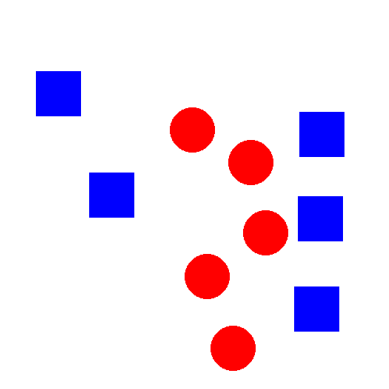

In [11]:
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt

# Параметры изображения
IMAGE_SIZE = (500, 500)  # Размер изображения
CIRCLE_RADIUS = 30       # Радиус кругов
SQUARE_SIZE = 60         # Размер стороны квадрата
NUM_SHAPES = 10          # Общее количество фигур (кругов и квадратов)

# Цвета для фигур
CIRCLE_COLOR = (255, 0, 0)  # Красный
SQUARE_COLOR = (0, 0, 255)  # Синий
BACKGROUND_COLOR = (255, 255, 255)  # Белый фон

# Создаем новое изображение
image = Image.new("RGB", IMAGE_SIZE, color=BACKGROUND_COLOR)
draw = ImageDraw.Draw(image)

# Функция для проверки пересечения двух прямоугольников
def is_overlapping(rect1, rect2):
    return not (rect1[2] <= rect2[0] or  # rect1 справа от rect2
                rect1[0] >= rect2[2] or  # rect1 слева от rect2
                rect1[3] <= rect2[1] or  # rect1 ниже rect2
                rect1[1] >= rect2[3])    # rect1 выше rect2

# Функция для проверки, что новая фигура не пересекается с существующими
def is_valid_position(new_shape, existing_shapes):
    for shape in existing_shapes:
        if is_overlapping(new_shape, shape):
            return False
    return True

# Список для хранения границ фигур
existing_shapes = []

# Генерация фигур
for _ in range(NUM_SHAPES):
    is_circle = random.choice([True, False])  # Случайный выбор: круг или квадрат
    attempts = 0
    max_attempts = 1000  # Ограничение попыток размещения фигуры

    while attempts < max_attempts:
        # Случайные координаты центра фигуры
        x = random.randint(0, IMAGE_SIZE[0])
        y = random.randint(0, IMAGE_SIZE[1])

        if is_circle:
            # Определяем границы круга
            left = x - CIRCLE_RADIUS
            top = y - CIRCLE_RADIUS
            right = x + CIRCLE_RADIUS
            bottom = y + CIRCLE_RADIUS
            circle_bounds = (left, top, right, bottom)

            # Проверяем, что круг помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(circle_bounds, existing_shapes):
                    draw.ellipse(circle_bounds, fill=CIRCLE_COLOR)  # Рисуем круг
                    existing_shapes.append(circle_bounds)
                    break
        else:
            # Определяем границы квадрата
            left = x - SQUARE_SIZE // 2
            top = y - SQUARE_SIZE // 2
            right = x + SQUARE_SIZE // 2
            bottom = y + SQUARE_SIZE // 2
            square_bounds = (left, top, right, bottom)

            # Проверяем, что квадрат помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(square_bounds, existing_shapes):
                    draw.rectangle(square_bounds, fill=SQUARE_COLOR)  # Рисуем квадрат
                    existing_shapes.append(square_bounds)
                    break

        attempts += 1

# Сохраняем изображение
image.save("color_shapes_image.png")
print("Изображение сохранено как 'color_shapes_image.png'")

# Отображаем изображение с помощью matplotlib
plt.imshow(image)
plt.axis('off')  # Отключаем оси
plt.show()

2. Выполните п.1 для цветного изображения, считая, что круги и квадраты имеют заданный цвет.

In [12]:
from PIL import Image
import numpy as np
from collections import deque

# Загрузка изображения
image = Image.open("color_shapes_image.png").convert("RGB")  # Цветное изображение
pixels = np.array(image)  # Преобразуем в массив NumPy

# Параметры изображения
rows, cols, _ = pixels.shape

# Цвета для кругов и квадратов (в формате RGB)
CIRCLE_COLOR = (255, 0, 0)  # Красный
SQUARE_COLOR = (0, 0, 255)  # Синий

# Направления для обхода соседей (4-связность)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Функция для поиска связной области заданного цвета
def find_connected_component(start_row, start_col, visited, target_color):
    queue = deque([(start_row, start_col)])
    visited[start_row][start_col] = True
    component = []

    while queue:
        row, col = queue.popleft()
        component.append((row, col))

        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if not visited[new_row][new_col] and tuple(pixels[new_row][new_col]) == target_color:
                    visited[new_row][new_col] = True
                    queue.append((new_row, new_col))

    return component

# Функция для классификации формы
def classify_shape(component):
    min_row = min(row for row, col in component)
    max_row = max(row for row, col in component)
    min_col = min(col for row, col in component)
    max_col = max(col for row, col in component)

    width = max_col - min_col + 1
    height = max_row - min_row + 1

    # Площадь ограничивающего прямоугольника
    bounding_box_area = width * height

    # Количество пикселей внутри связной области
    filled_area = len(component)

    # Отношение заполненной площади к площади ограничивающего прямоугольника
    fill_ratio = filled_area / bounding_box_area

    # Классификация по коэффициенту заполнения
    if abs(width - height) <= 2:  # Допустимая погрешность для ширины и высоты
        if fill_ratio > 0.9:  # Близко к 1 — это квадрат
            return "square"
        elif fill_ratio > 0.6:  # Примерно 0.785 — это круг
            return "circle"
    return None

# Поиск всех фигур
visited = np.zeros((rows, cols), dtype=bool)
circle_count = 0
square_count = 0

for row in range(rows):
    for col in range(cols):
        # Проверяем, является ли пиксель частью круга (красный цвет)
        if tuple(pixels[row][col]) == CIRCLE_COLOR and not visited[row][col]:
            component = find_connected_component(row, col, visited, CIRCLE_COLOR)
            shape_type = classify_shape(component)
            if shape_type == "circle":
                circle_count += 1

        # Проверяем, является ли пиксель частью квадрата (синий цвет)
        elif tuple(pixels[row][col]) == SQUARE_COLOR and not visited[row][col]:
            component = find_connected_component(row, col, visited, SQUARE_COLOR)
            shape_type = classify_shape(component)
            if shape_type == "square":
                square_count += 1

# Вывод результатов
print(f"Количество кругов: {circle_count}")
print(f"Количество квадратов: {square_count}")

Количество кругов: 5
Количество квадратов: 5


3. Возьмите изображение, которое содержит объекты и маркеры ARUCO. Сделайте из него 4 изображения с другими параметрами. Постройте график зависимости числа выделенных контуров на изображении от величины порогового уровня. Влияет ли качество изображения на это число?